# Load libraries

Training a CNN from scratch.

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras import *

# image processing
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import img_to_array

# build your own nets
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [3]:
train_image_files_path = "/keras2production/fruits/Training/"
valid_image_files_path = "/keras2production/fruits/Test/"

# Keras

https://keras.io/

In [4]:
fruit_list = ["Apricot", "Avocado", "Banana", "Clementine", "Cocos", "Kiwi", "Lemon", "Limes", 
              "Mandarine", "Orange", "Peach", "Pineapple", "Plum", "Pomegranate", "Raspberry", "Strawberry"]
output_n = len(fruit_list)
size = 20
img_width = 20
img_height = 20
channels = 3
batch_size = 32

In [5]:
train_data_gen = ImageDataGenerator(
    rescale = 1 / 255 #,
    
    # optional data augmentation ## instead of the original images will randomly modified and therefore those images will be kind of differnt -- see the help section
    #rotation_range = 40,
    #rwidth_shift_range = 0.2,
    #rheight_shift_range = 0.2,
    #rshear_range = 0.2,
    #rzoom_range = 0.2,
    #rhorizontal_flip = TRUE,
    #rfill_mode = "nearest"
)

valid_data_gen = ImageDataGenerator(
    # validation data shouldn't be augmented
    rescale = 1 / 255
)

train_image_array_gen = train_data_gen.flow_from_directory(
    train_image_files_path,
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    classes = fruit_list,
    color_mode = 'rgb', 
    batch_size = batch_size,
    seed = 42)

valid_image_array_gen = valid_data_gen.flow_from_directory(
    valid_image_files_path,
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    classes = fruit_list,
    color_mode = 'rgb', 
    batch_size = batch_size,
    seed = 42)

Found 7709 images belonging to 16 classes.
Found 2428 images belonging to 16 classes.


In [6]:
epochs = 3
train_samples = train_image_array_gen.n
valid_samples = valid_image_array_gen.n
print(train_samples, valid_samples)

7709 2428


In [7]:
model = Sequential()

# first hidden layer ## this is based on the theoretical sections that have been clearified in the beginning
### images are resized to 20x20 -- faster calculation
model.add(Conv2D(32, (3, 3), padding = "same", input_shape = (img_width, img_height, channels))) ## input chain has to be defined in the FIRST hidden layer
model.add(Activation('relu')) ## on second --- better seen in summary afterwords

# second hidden layer
model.add(Conv2D(16, (3, 3), padding = "same"))
model.add(LeakyReLU(alpha = 0.5)) ## leakyReLU is an advanced optimization
model.add(BatchNormalization())

# max pooling
model.add(MaxPooling2D(pool_size = (2,2))) ## pooling for 2-dimensional matrices
model.add(Dropout(0.25)) ## prevent overfitting

# Flatten max filtered output into feature vector 
# and feed into dense layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Outputs from dense layer are projected onto output layer
model.add(Dense(output_n))
model.add(Activation('softmax'))

In [8]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 16)        4624      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 20, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 16)        0         
__________

Compile the model

In [9]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = RMSprop(lr = 0.0001, decay = 1e-6),
              metrics = ['accuracy'])

In [10]:
history = model.fit_generator(
    train_image_array_gen,
    steps_per_epoch = int(train_samples / batch_size), 
    epochs = epochs, 
    validation_data = valid_image_array_gen,
    validation_steps = int(valid_samples / batch_size),
    verbose = 1
)

Epoch 1/3
240/240 [==============================] - 19s 81ms/step - loss: 0.8810 - acc: 0.7253 - val_loss: 0.1432 - val_acc: 0.9650
Epoch 2/3
240/240 [==============================] - 15s 64ms/step - loss: 0.1180 - acc: 0.9657 - val_loss: 0.0196 - val_acc: 0.9967
Epoch 3/3
240/240 [==============================] - 15s 63ms/step - loss: 0.0426 - acc: 0.9887 - val_loss: 0.0100 - val_acc: 0.9984


In [11]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


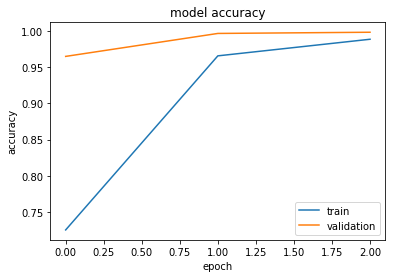

In [12]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'lower right')
plt.show()

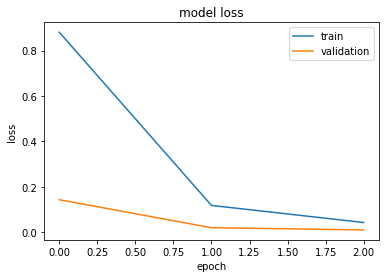

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

### Predict test data

In [14]:
test_image_files_path = "/keras2production/notebooks/1-deeplearning/test_images/"
test_images = !find $test_image_files_path -type f -name "*.jpg"
print(test_images)

['/keras2production/notebooks/1-deeplearning/test_images/Banana/Banana_wiki.jpg', '/keras2production/notebooks/1-deeplearning/test_images/Banana/.ipynb_checkpoints/Banana_wiki-checkpoint.jpg']


In [15]:
classes = train_image_array_gen.class_indices
classes

{'Apricot': 0,
 'Avocado': 1,
 'Banana': 2,
 'Clementine': 3,
 'Cocos': 4,
 'Kiwi': 5,
 'Lemon': 6,
 'Limes': 7,
 'Mandarine': 8,
 'Orange': 9,
 'Peach': 10,
 'Pineapple': 11,
 'Plum': 12,
 'Pomegranate': 13,
 'Raspberry': 14,
 'Strawberry': 15}

Define a function and apply the generated model.

In [17]:
def classify_image_model(image, classes=classes):
    img = cv2.imread(image)        
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    image = image_utils.load_img(image, target_size=(img_width, img_height))
    image = image_utils.img_to_array(image)

    image = np.expand_dims(image, axis=0)

    # scale pixels between -1 and 1, sample-wise
    image /= 255.
        
    prediction = model.predict(image)
    
    pred = prediction.argmax() ## the highest prediction probability 

    for k, v in classes.items():
        if (v == pred):
            pred_label = k
        
    proba = prediction.max() ## value here
    
    print("Predicted class: " + pred_label + " with probability " + str(proba*100) + "%")

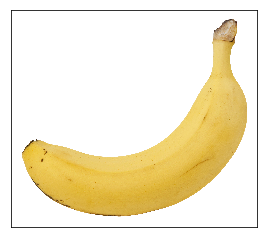

Predicted class: Banana with probability 99.99992847442627%


In [18]:
classify_image_model(test_images[0])

# Visualize the net

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

This will be not talked about in to much detail

In [19]:
img = image_utils.load_img(test_images[0], target_size=(20, 20))
img_tensor = image_utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)

print(img_tensor.shape)

(1, 20, 20, 3)


In [20]:
# Extracts the outputs of the top layers:
top = 7

layer_outputs = [layer.output for layer in model.layers[:top]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 20, 20, 32)


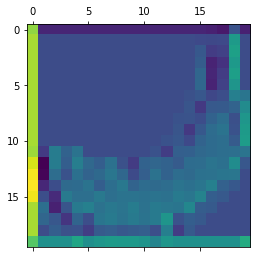

In [21]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

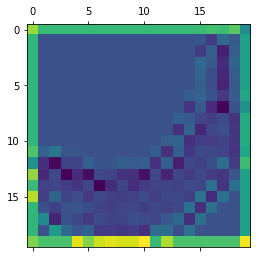

In [22]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

['conv2d_1', 'activation_1', 'conv2d_2', 'leaky_re_lu_1', 'batch_normalization_1', 'max_pooling2d_1', 'dropout_1']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


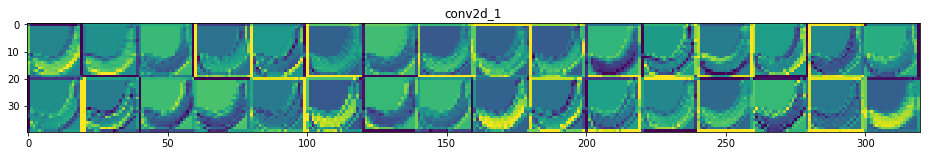

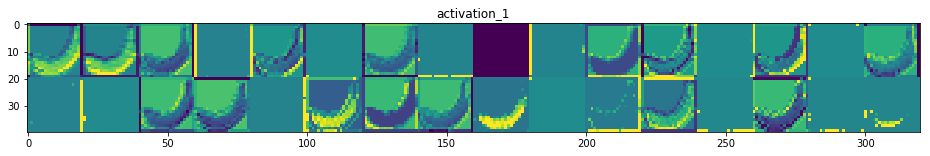

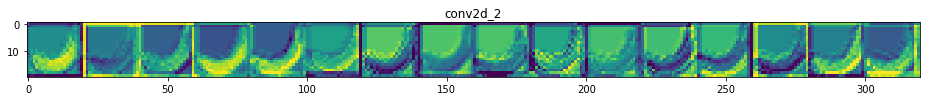

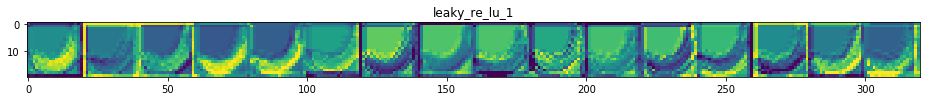

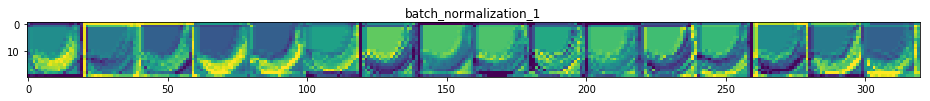

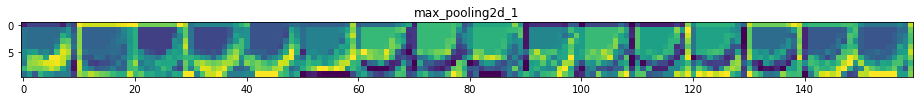

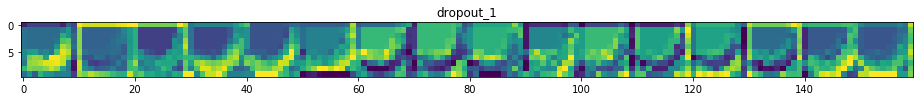

In [23]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:top]:
    layer_names.append(layer.name)
print(layer_names)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Save the prediction model as an `h5` model file.

In [24]:
model.save("/keras2production/notebooks/fruits.h5") 